# Importing packages

## Setup

In [63]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d
import pptk
from logging import raiseExceptions
import seaborn as sns
import funcs
import tensorflow as tf

%reload_ext funcs


## Data loader

original dataframe size (1066, 18)
 dataframe (688, 4)


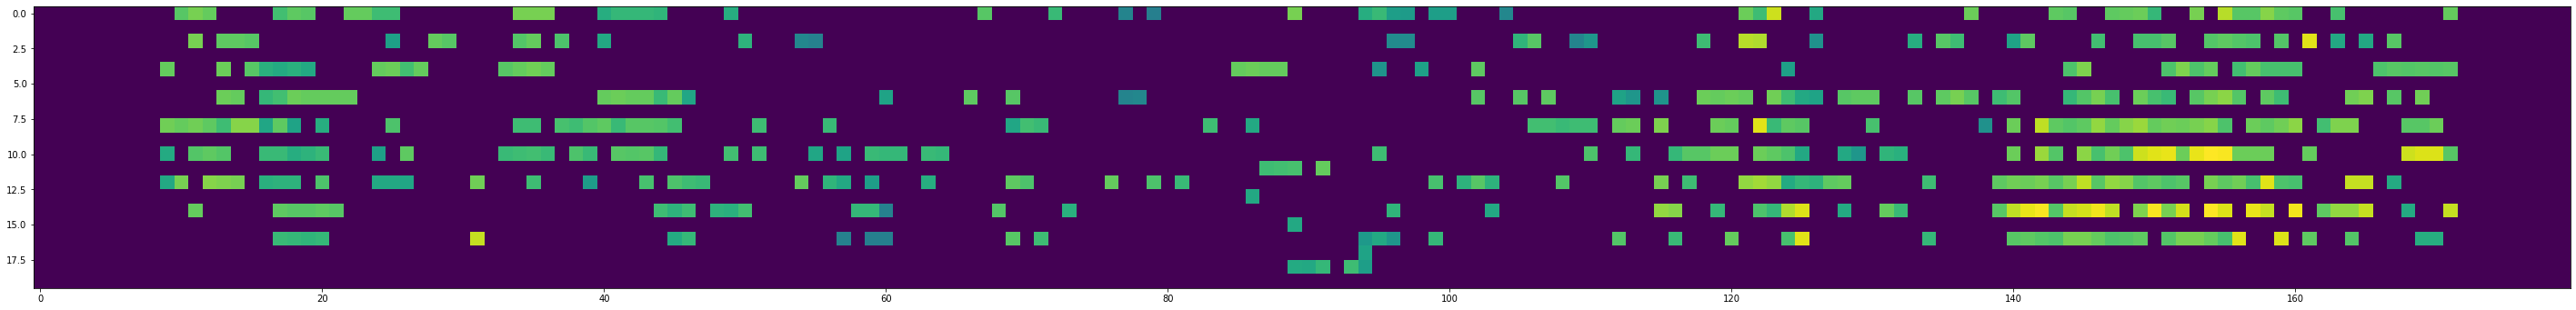

In [64]:
dataloader = funcs.DataLoader(modality='Radar' , data_type='matrix')
dataloader.get_data(filename='1_.txt')

print('original dataframe size', dataloader.dataframe_original.shape)
print(' dataframe',  dataloader.dataframe.shape )

plt.figure(figsize=(50,10))
plt.imshow(dataloader.data_matrix[:,:,0] / dataloader.data_matrix[:,:,0].max() )

In [65]:
x,y,z = dataloader.spherical_to_cartesian( Azimuth_Angle=dataloader.dataframe.Azimuth , Elevation_Angle=dataloader.dataframe.Elevation - 10 , Range=dataloader.dataframe.Range )

# plt.hist(z)

dataloader.dataframe

,Range,Azimuth,Elevation,RCS
0,1,31,16,85
1,1,54,2,43
2,1,55,2,41
3,1,56,8,40
6,1,57,16,41
...,...,...,...,...
1059,485,40,2,56
1060,496,44,0,61
1061,497,47,12,63
1063,499,46,16,62


In [66]:
# dataloader.dataframe_original

## <span style="color:orange; font-size:0.8em"> Viewing the point clouds </span>

In [67]:
columns = dataloader.dataframe.columns[:3]

# funcs.DataLoader().visualize(points=dataloader.dataframe[columns])

In [68]:
dataloader.dataframe[columns]

,Range,Azimuth,Elevation
0,1,31,16
1,1,54,2
2,1,55,2
3,1,56,8
6,1,57,16
...,...,...,...
1059,485,40,2
1060,496,44,0
1061,497,47,12
1063,499,46,16


## <span style="color:orange; font-size:0.8em"> Vector Input </span>

In [69]:
# loader = funcs.VectorInput(filename='1_.txt', modality='Radar')

# print(loader.dataframe.shape)
# print(loader.data.test.shape)

## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [70]:
loader = funcs.MatrixInput(modality='Radar')

Loading the dataset: 1683it [00:54, 30.79it/s]


Epoch 1/30
106/106 [==============================] - 3s 22ms/step - loss: 0.2278 - val_loss: 0.2055
Epoch 2/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1568 - val_loss: 0.1588
Epoch 3/30
106/106 [==============================] - 2s 23ms/step - loss: 0.1478 - val_loss: 0.1457
Epoch 4/30
106/106 [==============================] - 2s 22ms/step - loss: 0.1357 - val_loss: 0.1317
Epoch 5/30
106/106 [==============================] - 2s 20ms/step - loss: 0.1252 - val_loss: 0.1242
Epoch 6/30
106/106 [==============================] - 2s 19ms/step - loss: 0.1192 - val_loss: 0.1191
Epoch 7/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1156 - val_loss: 0.1152
Epoch 8/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1134 - val_loss: 0.1134
Epoch 9/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1118 - val_loss: 0.1119
Epoch 10/30
106/106 [==============================] - 2s 18ms/step - loss: 0.1106 - val_lo

(<AxesSubplot:title={'center':'input'}>,
 Text(0.5, 1.0, 'input'))

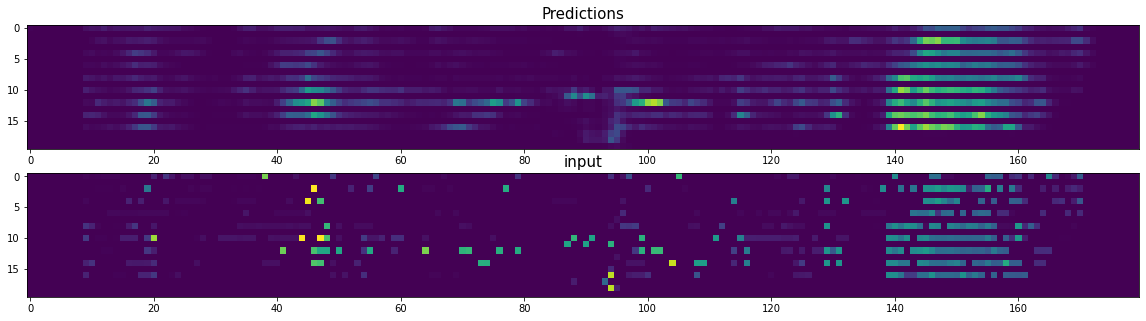

In [77]:
sample_ix = 10
channel = 1

plt.figure(figsize=(20,5))
plt.subplot(211), plt.imshow(loader.predictions[sample_ix,:,:,channel]), plt.title("Predictions", fontsize=15)
plt.subplot(212), plt.imshow(loader.dataset[sample_ix,:,:,channel]), plt.title("input", fontsize=15)

In [133]:
sample_ix = 10


# sample = loader.dataset[sample_ix,...]
sample = loader.predictions[sample_ix,...]



pred = loader.extract_spherical_coordinates(sample)

loader.visualize(points=pred, method='open3d')

,Elevation,Azimuth,RCS,Range,invRange
0,0.0,0.0,1.566925e-03,6.725107e-03,1.268575e-03
1,0.0,1.0,2.377801e-04,1.357747e-04,2.227338e-04
2,0.0,2.0,3.390172e-04,3.146929e-04,2.390857e-04
3,0.0,3.0,9.991832e-05,2.753111e-04,1.939231e-05
4,0.0,4.0,1.342035e-04,3.917155e-04,4.345143e-05
...,...,...,...,...,...
3595,19.0,175.0,9.106526e-09,2.106123e-10,8.071543e-11
3596,19.0,176.0,2.994582e-07,2.910526e-09,1.215523e-09
3597,19.0,177.0,6.278021e-07,1.087749e-08,7.061125e-09
3598,19.0,178.0,4.707999e-06,1.217263e-07,5.170921e-08
